In [1]:
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt

In [17]:
SERVICE = 5.0
ARRIVAL = 10.0
SIM_TIME = 100000
LOG_INTERVAL = 1000
epsilon = 0.0005

# we define detection window here to keeps only the latest values of relative changes 
# so with this value we say ok lets track the N changes in the avg delay and if
# all of them are small the system became stabalized 
detection_window = 50

TYPE1 = 1
arrivals = 0
users = 0

In [18]:
class Measure:
    def __init__(self, Narr, Ndep, NAveraegUser, OldTimeEvent, AverageDelay):
        self.arr = Narr
        self.dep = Ndep
        self.ut = NAveraegUser
        self.oldT = OldTimeEvent
        self.delay = AverageDelay

In [19]:

class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time

In [20]:
class Server:
    def __init__(self):
        self.idle = True

In [21]:
def arrival(time, FES, queue):
    global users
    data.arr += 1
    data.ut += users * (time - data.oldT)
    data.oldT = time
    # w schedule the next arrival using an exp interarrival time (poisson)
    inter_arrival = random.expovariate(1.0 / ARRIVAL)
    FES.put((time + inter_arrival, "arrival"))
    # count number of users in the system 
    users += 1
    client = Client(TYPE1, time)
    queue.append(client)
    # here check if the system was previously empty, if that was we start
    # serving the new client immediately by scheduling their departure 
    if users == 1:
        service_time = random.expovariate(1.0 / SERVICE)
        FES.put((time + service_time, "departure"))

$$
\text{Relative Change} = \frac{\left| \bar{W}_{\text{curr}} - \bar{W}_{\text{prev}} \right|}{\bar{W}_{\text{prev}}}
$$



In [22]:
def departure(time, FES, queue):
    global users, avg_delay_prev, steady_detected, steady_time, recent_changes

    # increment total departure and updates total user time again 
    data.dep += 1
    data.ut += users * (time - data.oldT)
    data.oldT = time

    # remove the served client from the queue and reduce the count
    client = queue.pop(0)
    users -= 1

    # measure delay here for the current client and accululates into total delay
    delay = time - client.arrival_time
    data.delay += delay

    #  compute the current avg delay 
    avg_delay_curr = data.delay / data.dep
    departure_log.append((time, avg_delay_curr))  # Track for plotting

    # once we have more than 1 departure 
    # compute how much the avg delay changed 
    # stor delay evolution for plotting 
    # we get the absolute difference btw the current avg delay(after this departure)
    # and the previous abg delay before this departure 
    # and then compute the percentage of changes btw successive avg delay values 
    if data.dep > 1:
        delta = abs(avg_delay_curr - avg_delay_prev)
        # if the avg_delay_prev is greater than 0 we calc the relative changes 
        # other wise go for the 1 as default value 
        relative_change = delta / avg_delay_prev if avg_delay_prev > 0 else 1
        delay_evolution.append((time, avg_delay_curr))

        # check if the change is less than epsilon
        if not steady_detected:
            recent_changes.append(relative_change)

            # keeps only the last detection window number of changes 
            if len(recent_changes) > detection_window:
                recent_changes.pop(0)

                # if all recent changes are below the threshold epsilon 
                # we declare that steady state detected and store the time
                if all(change < epsilon for change in recent_changes):
                    steady_detected = True
                    steady_time = time
                    
    # we save the current delay for comparison during the next deoarture 
    avg_delay_prev = avg_delay_curr

    # if there are still users waiting => start serving the next one 
    if users > 0:
        service_time = random.expovariate(1.0 / SERVICE)
        FES.put((time + service_time, "departure"))

In [23]:
random.seed(42)
data = Measure(0, 0, 0, 0, 0)
time = 0
FES = PriorityQueue()
MM1 = []
FES.put((0, "arrival"))

avg_delay_prev = 0
delay_evolution = []
departure_log = []  # New: log of (departure time, avg delay)
recent_changes = []
steady_detected = False
steady_time = None
next_log_time = LOG_INTERVAL
logs = []

while time < SIM_TIME:
    (time, event_type) = FES.get()
    if event_type == "arrival":
        arrival(time, FES, MM1)
    elif event_type == "departure":
        departure(time, FES, MM1)

    if time >= next_log_time:
        avg_users = data.ut / time
        avg_delay = data.delay / data.dep if data.dep > 0 else 0
        logs.append((time, avg_users, avg_delay))
        next_log_time += LOG_INTERVAL


Steady state detected at time: 20864.114434134997


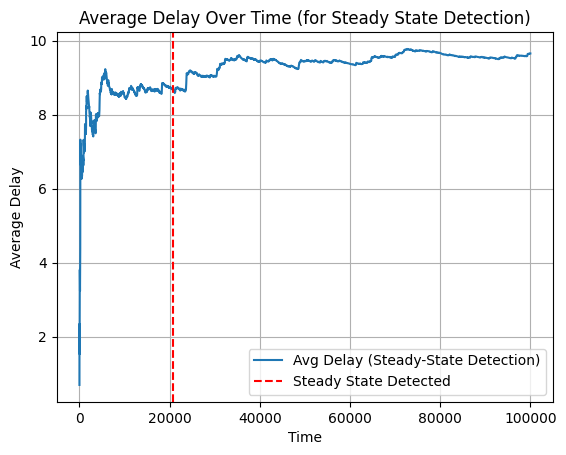

In [24]:
if steady_detected:
    print(f"Steady state detected at time: {steady_time}")
else:
    print("Steady state not detected within simulation time.")

# Plot delay evolution (for steady state detection)
times = [t for (t, d) in delay_evolution]
delays = [d for (t, d) in delay_evolution]

plt.figure()
plt.plot(times, delays, label='Avg Delay (Steady-State Detection)')
if steady_detected:
    plt.axvline(x=steady_time, color='r', linestyle='--', label='Steady State Detected')
plt.xlabel("Time")
plt.ylabel("Average Delay")
plt.title("Average Delay Over Time (for Steady State Detection)")
plt.grid(True)
plt.legend()
plt.show()

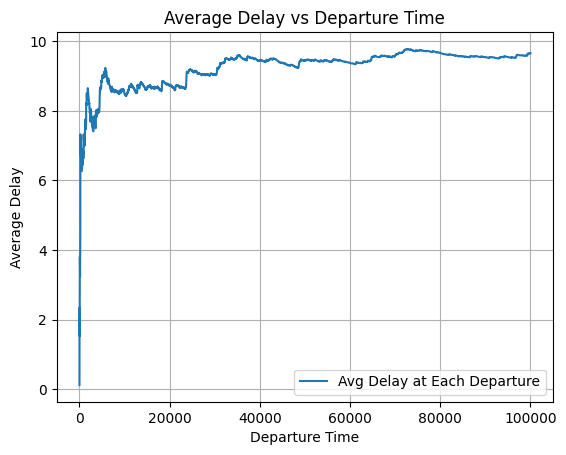

In [26]:
# Plot departure time vs average delay
dep_times = [t for (t, d) in departure_log]
dep_delays = [d for (t, d) in departure_log]

plt.figure()
plt.plot(dep_times, dep_delays, label='Avg Delay at Each Departure')
plt.xlabel("Departure Time")
plt.ylabel("Average Delay")
plt.title("Average Delay vs Departure Time")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
1.b - Try to apply a method to remove the warm-up transient in your simulations.

In [27]:
# Detect steady-state segment

# here we create a new list of logs and filter the original logs list to include 
# only data after the system reaches steady-state 
# then we make sure that after detection of the steady state it is happening 
# if the steady state was actually found 
steady_logs = [(t, u, d) for (t, u, d) in logs if steady_detected and t >= steady_time]

# here just splitind data for plotting 
steady_times = [t for (t, u, d) in steady_logs]
steady_users = [u for (t, u, d) in steady_logs]
steady_delays = [d for (t, u, d) in steady_logs]

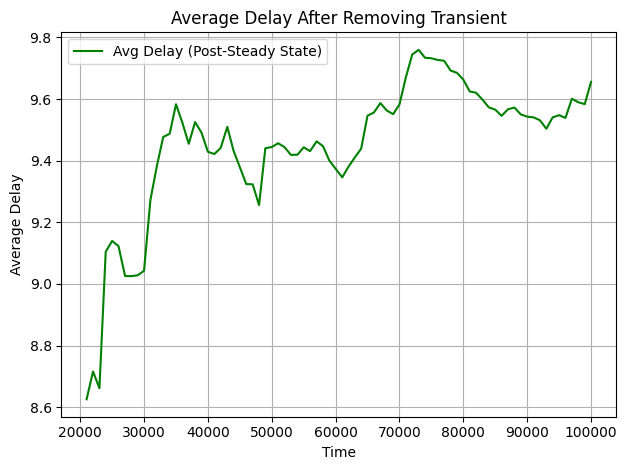

In [28]:

# Plot avg delay post steady state
plt.figure()
plt.plot(steady_times, steady_delays, label='Avg Delay (Post-Steady State)', color='green')
plt.xlabel("Time")
plt.ylabel("Average Delay")
plt.title("Average Delay After Removing Transient")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

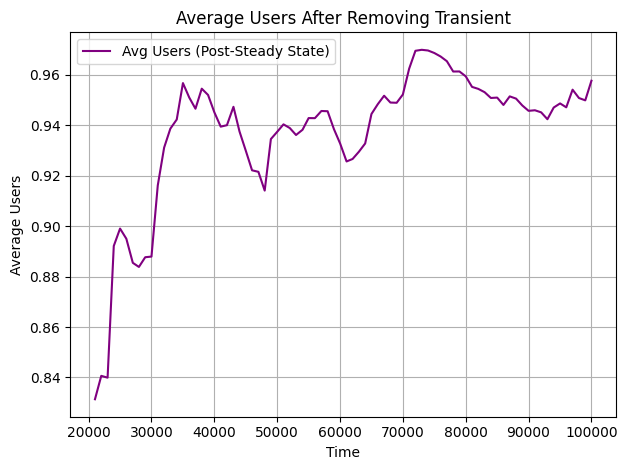

In [29]:
# Plot avg users post steady state
plt.figure()
plt.plot(steady_times, steady_users, label='Avg Users (Post-Steady State)', color='purple')
plt.xlabel("Time")
plt.ylabel("Average Users")
plt.title("Average Users After Removing Transient")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Final averages
if steady_detected and steady_logs:
    steady_avg_delay = sum(d for (_, _, d) in steady_logs) / len(steady_logs)
    steady_avg_users = sum(u for (_, u, _) in steady_logs) / len(steady_logs)

    print(f" Steady-state detected at time: {steady_time}")
    print(f" Steady-State Average Delay: {steady_avg_delay:.5f}")
    print(f" Steady-State Average Users: {steady_avg_users:.5f}")
else:
    print(" Steady state not detected or no post-steady data available.")

 Steady-state detected at time: 20864.114434134997
 Steady-State Average Delay: 9.44843
 Steady-State Average Users: 0.93708
